# Counting Stars (V5)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import pylab

from photutils.detection import DAOStarFinder

from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.stats import sigma_clipped_stats

imgFile = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True)

hdulist = fits.open(imgFile)
img = hdulist[0].data

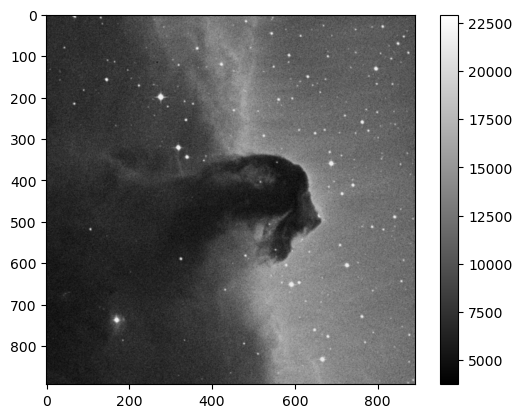

In [2]:
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

# Annulus

**Todo**:
- Investigate different background and circular aperture sizes

In [6]:
from PIL import Image
im_frame = Image.open('/home/saphio/repo/counting_stars/annuli_imgs/annulus_21.png')

In [7]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

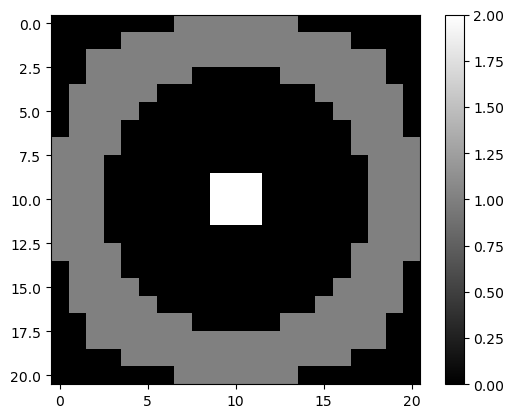

In [8]:
## Fixing up imported annulus

annulus = np.zeros((annulus_size, annulus_size))
for i in range(len(np_frame)):
    for j in range(len(np_frame[0])):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star

plt.imshow(annulus, cmap='gray')
plt.colorbar()
plt.show()

# Signal to Noise Ratio Function

In [9]:
def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

# Threshold Investigation
**Todo**:
- Fit gaussian distribution on histogram output 
    - determine how well it fits the histogram
- Determine how to best find the threshold
    - idea 1: estimate 3 SD to 5 SD away from the mean
    - idea 2: noise is gaussian, signal is not; things that don't fit the gaussian distribution are the signal (look at outliers)
    - idea 3: just explore different thresholds, could use binary search method to speed up the process

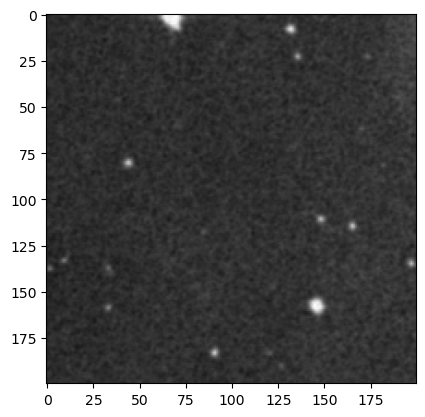

In [13]:
# testImg = img
testImg = img[:200, :200]
plt.imshow(testImg, cmap='gray', vmin=3759, vmax=22918)
plt.show()

In [14]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

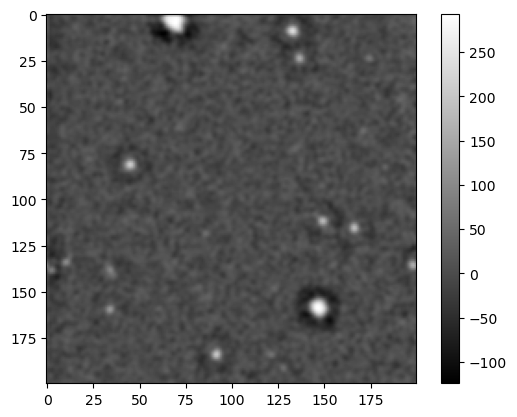

In [15]:
plt.imshow(snrImg, cmap='gray')
plt.colorbar()
plt.show()

In [16]:
snrData = snrImg.flatten()

**Todo**:
- fix QQ plot

amp 1363.1695987306312 
mean -1.2053812707443115 
sigma 11.751309467127246


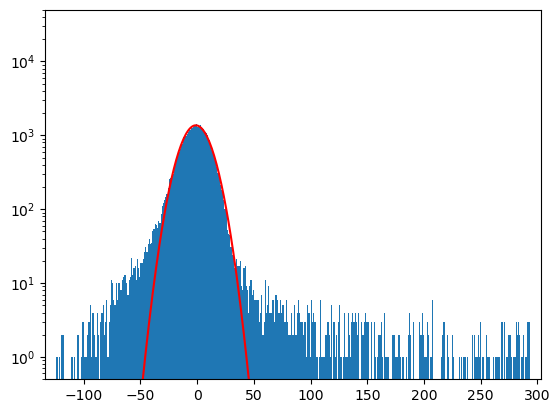

In [17]:
## histogram
n, bins, _ = plt.hist(snrData, bins=400, log=True)

## fitting gaussian curve
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

x = np.linspace(min(snrData), max(snrData), 400)
y = n

popt, pcov = curve_fit(gaussian, x, y)
plt.plot(x, gaussian(x, *popt), c='r')

plt.axis([min(snrData) - 10, max(snrData) + 10, 0.5, 50000])

## fit parameters
print('amp', popt[0], '\nmean', popt[1], '\nsigma', popt[2])
amp, mean, stdev = popt

plt.show()

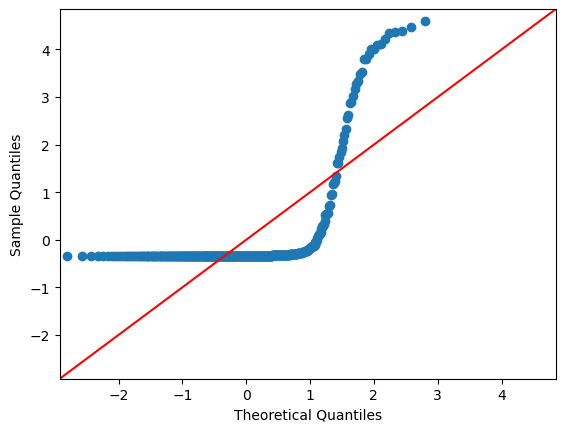

In [23]:
# TO FIX
# sm.qqplot(n, fit=True, line='45')

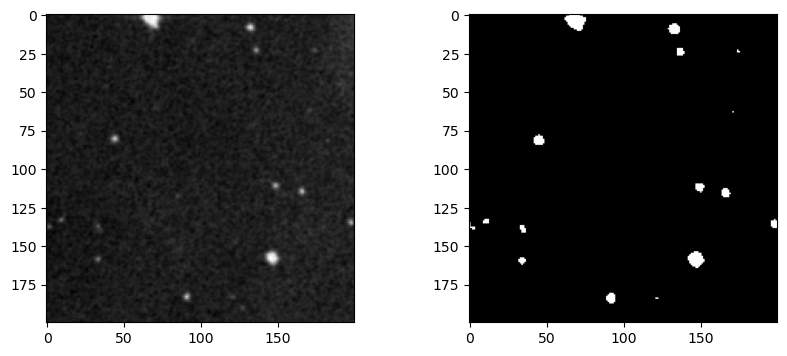

In [112]:
threshold = mean + 4.5 * stdev

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray')
axes[1].imshow(imgCut, cmap='gray')

plt.show()

# Counting the Stars

In [113]:
def neighbor (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [114]:
matrix = [[False for i in range(len(img[0]))] for j in range(len(img))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (neighbor(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [115]:
print('count', count)

16

# DAO Star Finder
Using the DAOFIND algorithm

In [29]:
mean_bg, median_bg, bg_sd = sigma_clipped_stats(img, sigma=3.0)

In [119]:
daofind = DAOStarFinder(fwhm=7.0, threshold=2*bg_sd)

srcs = daofind(img - median_bg)

print(srcs)

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,67.235221895396,2.249924444236729,0.3165737602395129,0.46330324565498476,-0.857677940609717,81,0.0,12319.0,3.8571015678808793,-1.4656526879023528
2,488.68526362734076,2.7598205800893174,0.3376111872146256,0.09406830163741003,-0.9109135553718539,81,0.0,4633.0,1.0694789733187746,-0.07293062616929537
3,131.8306580669185,8.15131696224384,0.5489578233262524,0.07348100034241024,-0.050180001976016575,81,0.0,11039.0,4.3381182215259395,-1.5932534578634614
4,546.8459343839064,8.619118989510708,0.6703760079333222,-0.5471571727009471,0.29340148655924425,81,0.0,9090.0,2.0550195793217125,-0.7820399099960007
5,261.9552714076116,12.582022940287755,0.8209429488233683,0.0829345003724524,-0.20115553111047904,81,0.0,5753.0,1.0374023546107836,-0.039868073461704734
6,482.5325990452759,16.961460937850614,0.364009393973394,0.1935955635170064,-0.03759317513227096,81,0.0,11422.0,3.241714308569061,-1.2769368448506904
...,...,...,...,...,...,...,...,...,...,...
201,876.3137702849197,838.9909399370232,0.6041660676832002,-0.09460628689554551,-0.03643557826682276,81,0.0,9556.0,2.177533510133871,-0.8449121177575152
202,445.4595400029228,865.6234813101399,0.7060487973291815,-0.5375490077090161,-0.18115023360975843,81,0.0,4418.0,1.6413548956954984,-0.538006237181791


In [109]:
x_coords = np.array(srcs['xcentroid'])
y_coords = np.array(srcs['ycentroid'])

(893.0, 0.0)

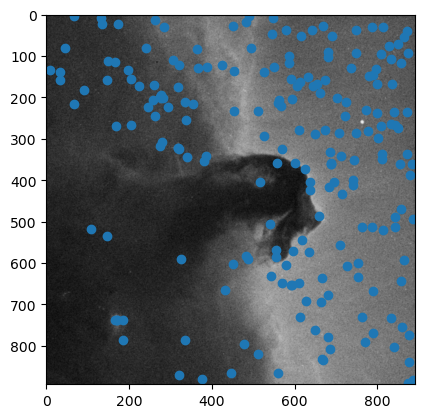

In [125]:
fig, axes = plt.subplots()

axes.imshow(img, cmap='gray')
axes.scatter(x_coords, y_coords)
axes.set_xlim(0, 891)
axes.set_ylim(893, 0)
plt.show()

## seems the algorithm found most of the stars... but not all of them!